# Business Case 

A significant part of the sales at Albert Heijn are promotion sales. In order to run a successful promotion campaign, it is important to obtain an understanding of the uplift in sales of certain items when put on promotion. This is not only necessary to decide on what type of promotions to run, but also to get an idea of the required stock levels to discuss orders with our suppliers.


# Task

* Create a model to forecast sales one week ahead on an article level. 

* Use the provided dataset.parquet file to build and evaluate your models. The dataset contains daily sales data at a national level for a number of articles during 2016 and 2017. More specific details about the dataset are given below

 
## Hard Requirements 

Note that the interview round will only go forward if all the below requirements are met: 

* Deadline <b>Monday 10:00 AM (Amsterdam Local Time)</b> before your scheduled interview 

* Your code is in <b>Python</b>

* A <b>Jupyter Notebook</b> where we can see the results of your work, and follow how you approached the problem. Not all your code has to be in the notebook, you can also use scripts or a package to build your solution, but we want to be able to see the results easily.

* Your solution contains <b> at least the following components</b>: an EDA, a working model and model evaluation 


## Hints 

* Manage your time. Start simple, and ensure you have all the required components and that they are working.

* We don't need an essay, but it's helpful to note where you've made assumptions or decisions in your Notebook (in markdown) You can also write down ideas about things you tried that didn't work or things you would still like to try out.

* Explain your Feature Engineering 

* Explain your Modeling choices 

* Explain your Model Evaluation and choice of metric(s). 

* Explain next steps to deploy your solution in production.


## Interview focus

During the interview we are most interested in the following:

1. Your understanding of how your model is performing with respect to the business problem
2. Your ability explain the assumptions and modelling decisions you have made
3. Your plan for how you would put this model into production

### Explanation of data: 

The dataset contains (obfuscated) sales history for 300 items at a national level. Below is an explanation of the columns in the dataset.

* DateKey: date identifier
* StoreCount: number of stores the article is available at
* ShelfCapacity: total capacity of shelfs over all stores
* PromoShelfCapacity: additional ShelfCapacity during promotion 
* UnitPromotionThreshold: minimal number of articles per basket before promotion is applied
* IsPromo: indicator if article is in promotion 
* national_holiday_[…]: indicator for specified holiday 
* SchoolHoliday[…]: indicator for holiday in north, middle or south part of NL 
* Temp[…]: minimal/maximum/average temperature of day 
* RainFallSum: total rainfall during the day (mm) 
* SundurationSum: total hours of sun during the day 
* MinAge: minimal accepted age to buy article 
* AlcoholPercentage: alcohol percentage of the article 
* CommunicationChannel: type of communication of promotion
* ItemNumber: item identification number
* CategoryCode: catergory identification number (product hierarchy) 
* GroupCode: group identification number (product hierarchy) 
* UnitSales: number of consumer units sold (**this is the target for the prediction**)
* DiscountPercentage: discount percentage applied when threshold is reached 
* BasePrice: price of article when article is not in promotion

## Getting started
The data for this interview case is provided in a parquet file that can be loaded directly into a pandas dataframe as shown below. In order for reading parquet file make sure the pyarrow package is installed.

In [1]:
# import the data
import pandas as pd
import random
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 5)
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

#Pandas option
pd.options.display.float_format = '{:.2f}'.format

In [2]:
# path to the data parquet file
path = "../data/dataset_300_items.parquet"

df = pd.read_parquet(path)
df.head(5)

,DateKey,StoreCount,ShelfCapacity,PromoShelfCapacity,UnitPromotionThreshold,IsPromo,national_holiday_new_years_day,national_holiday_good_friday,national_holiday_easter_sunday,national_holiday_easter_monday,...,SundurationSum,MinAge,AlcoholPercentage,CommunicationChannel,ItemNumber,CategoryCode,GroupCode,UnitSales,BasePrice,DiscountPercentage
728,20160104,187,11712.00,0,NaN,False,0,0,0,0,...,1.73,NaN,NaN,None,9021,7289,5524,610.00,NaN,NaN
729,20160105,187,11712.00,0,NaN,False,0,0,0,0,...,1.39,NaN,NaN,None,9021,7289,5524,674.00,NaN,NaN
730,20160106,187,11712.00,0,NaN,False,0,0,0,0,...,1.62,NaN,NaN,None,9021,7289,5524,650.00,NaN,NaN
731,20160107,187,11712.00,0,NaN,False,0,0,0,0,...,0.93,NaN,NaN,None,9021,7289,5524,642.00,NaN,NaN
732,20160108,187,11712.00,0,NaN,False,0,0,0,0,...,5.41,NaN,NaN,None,9021,7289,5524,1019.00,NaN,NaN


### Function Definitions

In [3]:
# function to count missing values in dataframe
def count_missings(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum() / df.isnull().count() * 100).sort_values(ascending = False)
    table = pd.concat([total, percent], axis = 1, keys = ["Total", "Percent"])
    table = table[table["Total"] > 0]
    return table

## Exploratory Data Analysis

In [4]:
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns in the dataframe")

There are 136809 rows and 35 columns in the dataframe


In [5]:
#Let's check the col types in our dataframe
df.dtypes

DateKey                                int32
StoreCount                             int64
ShelfCapacity                        float64
PromoShelfCapacity                     int64
UnitPromotionThreshold               float64
IsPromo                                 bool
national_holiday_new_years_day         int32
national_holiday_good_friday           int32
national_holiday_easter_sunday         int32
national_holiday_easter_monday         int32
national_holiday_kings_day             int32
national_holiday_rememberance_day      int32
national_holiday_liberation_day        int32
national_holiday_ascension             int32
national_holiday_white_sunday          int32
national_holiday_white_monday          int32
national_holiday_christmas             int32
national_holiday_boxing_day            int32
SchoolHolidayMiddle                  float64
SchoolHolidayNorth                   float64
SchoolHolidaySouth                   float64
TempMin                              float64
TempMax   

In [6]:
# Let's convert the date column to an actual datetime object
df['Date'] = pd.to_datetime(df['DateKey'].astype(str), format='%Y%m%d')
df.drop(['DateKey'], axis=1, inplace=True)
df.sort_values(by="Date", inplace=True)

In [7]:
df.tail()

,StoreCount,ShelfCapacity,PromoShelfCapacity,UnitPromotionThreshold,IsPromo,national_holiday_new_years_day,national_holiday_good_friday,national_holiday_easter_sunday,national_holiday_easter_monday,national_holiday_kings_day,...,MinAge,AlcoholPercentage,CommunicationChannel,ItemNumber,CategoryCode,GroupCode,UnitSales,BasePrice,DiscountPercentage,Date
1110941,678,8663.00,0,1.00,True,0,0,0,0,0,...,NaN,NaN,STORE,9873,7291,5550,1808.00,1.29,0.26,2017-12-31
1037006,412,7902.00,0,NaN,False,0,0,0,0,0,...,NaN,NaN,None,10623,7289,5604,241.00,NaN,NaN,2017-12-31
171567,535,5163.00,0,NaN,False,0,0,0,0,0,...,NaN,NaN,None,10243,7292,5556,216.00,NaN,NaN,2017-12-31
1336088,546,6894.00,0,2.00,True,0,0,0,0,0,...,NaN,NaN,LEAFLET_FULL_PAGE,10842,7292,5541,75.00,4.94,0.25,2017-12-31
253379,385,2558.00,0,NaN,False,0,0,0,0,0,...,NaN,NaN,None,11291,7289,5519,105.00,NaN,NaN,2017-12-31


The time series data consists of data from 2016-04-01 to 2017-12-31

Check for null values in dataframe

In [8]:
null_table = count_missings(df)
null_table

,Total,Percent
MinAge,136809,100.00
AlcoholPercentage,136809,100.00
UnitPromotionThreshold,126336,92.34
CommunicationChannel,126221,92.26
DiscountPercentage,126221,92.26
BasePrice,126221,92.26
SchoolHolidaySouth,94808,69.30
SchoolHolidayMiddle,94808,69.30
SchoolHolidayNorth,94808,69.30
UnitSales,7004,5.12


The MinAge and AlcoholPercentage columns have all nulls, so we can remove the columns of the purpose of this exercise.

In [9]:
df.drop(['MinAge', 'AlcoholPercentage'], axis=1, inplace=True)

Let's explore the data to get an idea of what features we should build for the model

In [10]:
#Some unit sales values are null
df_us = df[df.UnitSales.isna()]

In [11]:
df_us.shape

(7004, 33)

In [12]:
df_us.Date.value_counts()

2017-12-25    35
2017-01-01    31
2016-12-25    24
2017-04-16    23
2017-06-04    20
              ..
2016-05-06     4
2016-04-29     4
2016-04-23     4
2016-05-03     3
2016-04-30     3
Name: Date, Length: 728, dtype: int64

In [13]:
df_us.ItemNumber.value_counts()

8958     606
9644     520
9853     492
10873    457
11201    442
        ... 
10811      1
9101       1
8738       1
9668       1
10666      1
Name: ItemNumber, Length: 101, dtype: int64

The dates where the UnitSales are null look random. This is just to rule out that the nulls were actually for some kind of prediction set.

Let's look at the categories and groups

In [14]:
# Let's look at the categories
df.CategoryCode.value_counts()

7292    59415
7289    43544
7291    33850
Name: CategoryCode, dtype: int64

There are 3 categories which are further split into subcategories.

In [15]:
# Let's explore one category and examine
# how it is borken up
df_7292 = df.loc[df['CategoryCode'] == 7292]
df_7292.GroupCode.value_counts()[0:10]

5556    8069
5575    5600
5595    3899
5612    3686
5594    3249
5592    3052
5577    2765
5494    2190
5606    2184
5615    2002
Name: GroupCode, dtype: int64

Each category consists of group codes and each group code consists of item numbers, which makes this a hierarchial forecasting problem


In [16]:
# Let's examine 
df_7292_5556 = df_7292.loc[df_7292['GroupCode'] == 5556]
df_7292_5556.ItemNumber.value_counts()[0:10]

10838    728
11209    728
10981    728
8878     728
9832     728
8269     728
9315     728
9261     728
8436     728
10243    525
Name: ItemNumber, dtype: int64

For the purpose of visualization,, let's create pick 4 items at random and see how daily sales are for those items.

In [17]:
df_top = df.groupby(['ItemNumber', 'Date'])['UnitSales'].sum().reset_index()
item_list = random.sample(list(df_top['ItemNumber'].unique()), 4)
df_items = df_top.loc[df_top["ItemNumber"].isin(item_list)]
df_items.shape

(2121, 3)

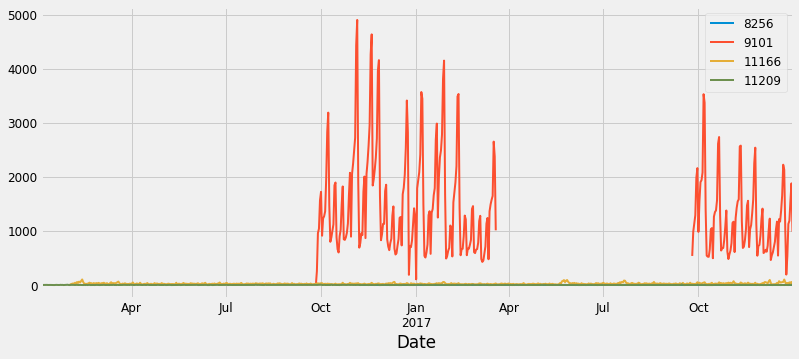

In [18]:
df_items_pivot = df_items.pivot(index='Date',columns='ItemNumber',values='UnitSales')
ax = df_items_pivot.plot(linewidth=2, fontsize=12);

# set label and legend
ax.set_xlabel('Date');
ax.legend(fontsize=12);

The above plot shows the challenges with forecasting because for some items, there is no data available after or before a certain period. We need to factor these when building a forecasting model. For some items, we might have to use a simpler weighted avg kind of model.

Let's look at category sales

In [19]:
df_cat = df.groupby(['CategoryCode', 'Date'])['UnitSales'].sum().reset_index()
df_cat.head()

,CategoryCode,Date,UnitSales
0,7289,2016-01-04,34378.00
1,7289,2016-01-05,34779.00
2,7289,2016-01-06,36191.00
3,7289,2016-01-07,41177.00
4,7289,2016-01-08,60698.00


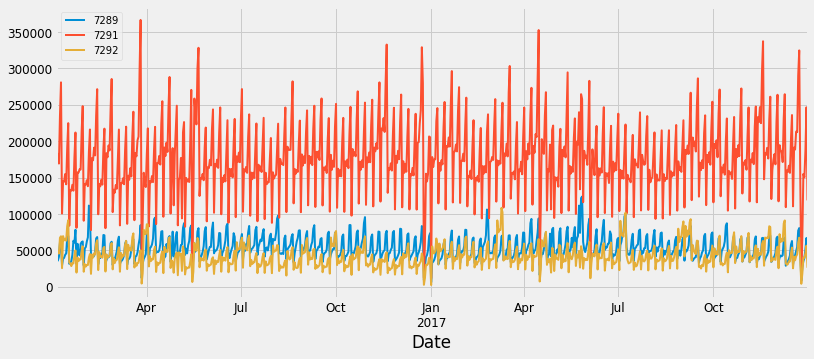

In [20]:
df_cat_pivot = df_cat.pivot(index='Date',columns='CategoryCode',values='UnitSales')
ax = df_cat_pivot.plot(linewidth=2, fontsize=12);

# set label and legend
ax.set_xlabel('Date');
ax.legend(fontsize=10);

### Seasonality by days of week and month

Let's examine the total sales by weekday to identify as patterns

Text(0.5, 1.0, 'Avg item sales by weekday')

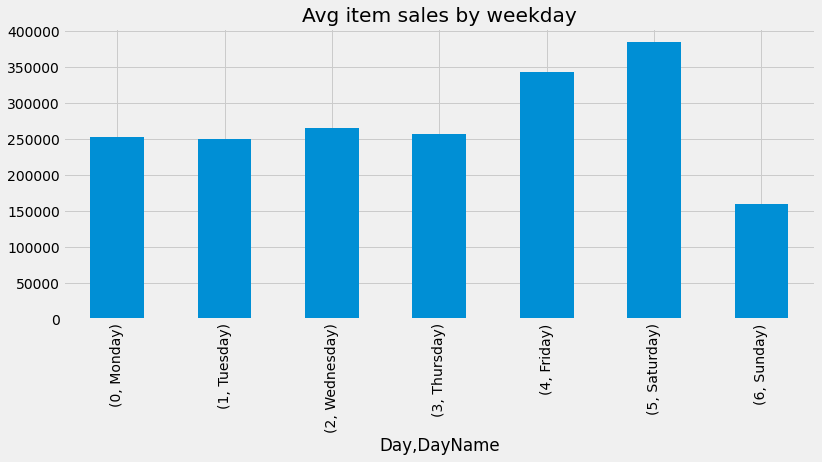

In [21]:
df_total = df.groupby(["Date"])["UnitSales"].sum().reset_index()
df_total["Day"] = df_total["Date"].dt.dayofweek
df_total["DayName"] = df_total["Date"].dt.day_name()

df_total[["Day", "UnitSales", "DayName"]].groupby(
    ["Day", "DayName"]
).mean().sort_index().plot(kind="bar", legend=None)
plt.title("Avg item sales by weekday")


There are some patterns in the sales by weekday. Friday and Saturday seem to be the days with highest avg sales. We should include weekday as one of the features in our model.

Text(0.5, 1.0, 'Avg item sales by month')

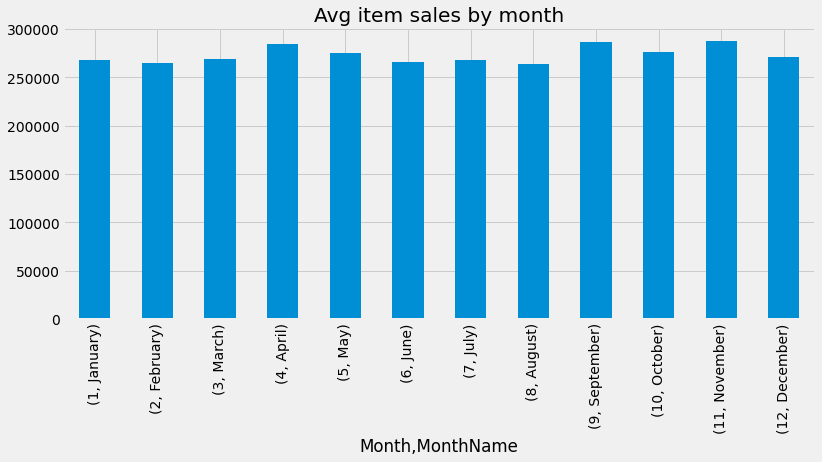

In [22]:
df_total["Month"] = df_total["Date"].dt.month
df_total["MonthName"] = df_total["Date"].dt.month_name()

df_total[["Month", "UnitSales", "MonthName"]].groupby(
    ["Month", "MonthName"]
).mean().sort_index().plot(kind="bar", legend=None)
plt.title("Avg item sales by month")


The monthly seasonality is not as significant as the weekday one, but we can some seasonality in the avg monthly sales. This could be due to less sales on months with holidays as people are traveling or eating out more often.

### Split dataset by items

As we saw earlier, some items do not have sales data for most of the days given in the dataset. It should be useful to look at the distribution of days avalable per item.

In [23]:
df_item = (
    df.ItemNumber.value_counts()
    .to_frame()
    .reset_index()
    .rename(columns={"index": "ItemNumber", "ItemNumber": "CountofDays"})
)
df_item.head()


,ItemNumber,CountofDays
0,9021,728
1,8918,728
2,8132,728
3,11018,728
4,8756,728


<AxesSubplot:>

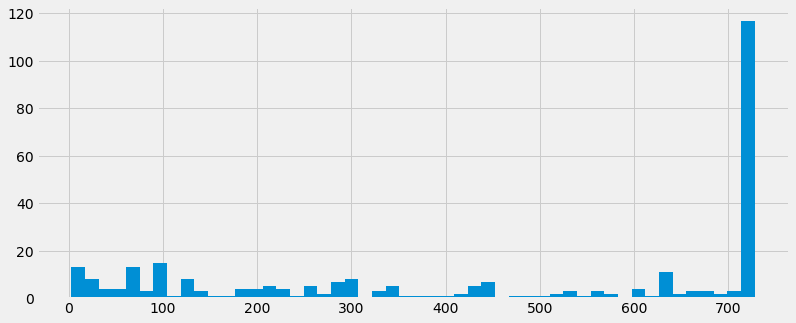

In [24]:
df_item['CountofDays'].hist(bins=50)

Around 100+ items have sales data for the entire 728 days. For the purpose of this exercise I will filter out those items and build a forecast with a machine learning model. For the other items we will use a naive model that takes the verage of the last 4 weeks.

In [25]:
# list of unique item numbers that will go into the ml model
ml_list = list(df_item.loc[df_item['CountofDays'] == 728]['ItemNumber'].unique())
# list of unique item numbers that will use a naive model
ma_list = list(df_item.loc[df_item['CountofDays'] != 728]['ItemNumber'].unique())

Let's filter out the data frame to create 2 separate dataframes using the 2 lists we created above.

In [26]:
# for our ml model
df_ml = df.loc[df.ItemNumber.isin(ml_list)]
# for naive model
df_ma = df.loc[df.ItemNumber.isin(ma_list)]

In [29]:
# save the dataframes for use later
df_ml.to_pickle("../data/df_ml.pkl")
df_ma.to_pickle("../data/df_ma.pkl")